In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("fivethirtyeight")

# Data Preparation

The poetry dataset is downloaded from [Kaggle](https://www.kaggle.com/paultimothymooney/poetry).

In [2]:
import os

DATASET_DIR = '../../dataset/poetry-lyrics/'

In [3]:
poetry = {
    'artist': [],
    'text': []
}

for file_name in os.listdir(DATASET_DIR):
    file = open(DATASET_DIR + file_name)
    sentences = []
    for line in file:
        sentences.append(line.replace('\n',''))
    file.close()
    poetry['artist'].append([
        file_name.replace('.txt','').replace('_','-').lower()
    ] * len(sentences)
    )
    poetry['text'].append(sentences)

In [4]:
from itertools import chain

df_poetry = pd.DataFrame(
    data = {
        'artist': list(chain.from_iterable(poetry['artist'])),
        'text': list(chain.from_iterable(poetry['text']))
    }
)

## remove records with empty text
df_poetry = df_poetry[~(df_poetry['text'] == '')].copy()

In [6]:
## standardize artist name
df_poetry['artist'] = np.where(
    (df_poetry['artist'] == 'kanye'),
    'kanye-west',
    df_poetry['artist']
)

In [7]:
import re

## lowercase text
df_poetry['text_cleaned'] = df_poetry['text'].str.lower().str.replace("'",'')
## remove non-alphanumeric
df_poetry['text_cleaned'] = df_poetry['text_cleaned'].apply(lambda x: re.sub(r'[^A-Za-z0-9]+', ' ', x))

df_poetry['text_cleaned_with_flag'] = df_poetry['text_cleaned'].apply(
    lambda x: ' ' .join(['STARTFLAG'] + x.split(' ') + ['ENDFLAG'])
)

In [19]:
df_poetry.iloc[2]

artist                                                     dolly-parton
text                                     Jolene, Jolene, Jolene, Jolene
text_cleaned                                jolene jolene jolene jolene
text_cleaned_with_flag    STARTFLAG jolene jolene jolene jolene ENDFLAG
Name: 2, dtype: object

In [20]:
df_poetry.shape

(175986, 4)

In [26]:
df_poetry['artist'].nunique()

45

# Initial exploration

Check number of records per artist, and the most common words.
We intentionally do not remove the stopwords, punctuations, etc. because they are useful for the language model.

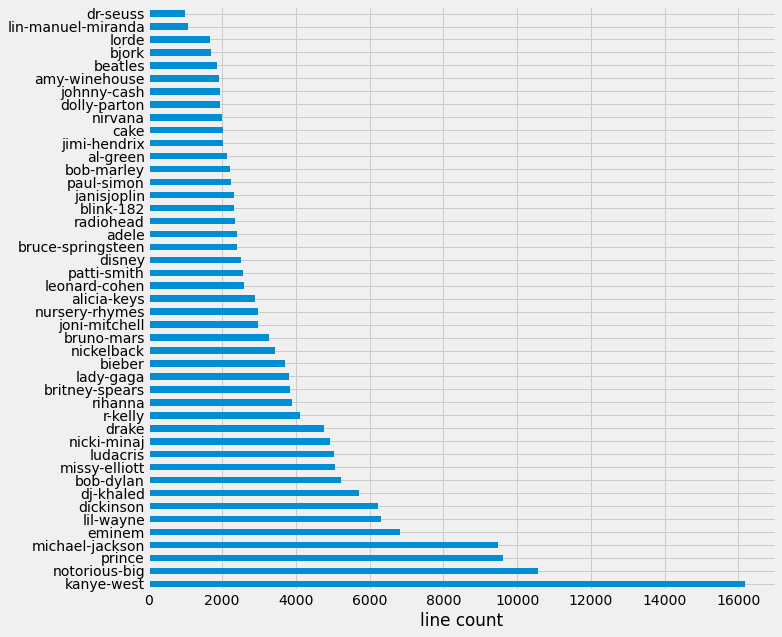

In [25]:
f, ax = plt.subplots(figsize = (10,10))
df_poetry['artist'].value_counts().plot.barh(ax=ax);
plt.xlabel("line count");
sns.despine();

In [32]:
from collections import Counter

def view_keywords(df, category_column, category_value, text_column, top_n=5):
    tokens = df[df[category_column] == category_value][text_column]
    all_tokens = []
    for token_list in tokens:
        if token_list == ' ':
            continue
        all_tokens += token_list.split(' ')
    
    counter = Counter(all_tokens)
    return counter.most_common(top_n)

In [33]:
view_keywords(
    df_poetry,
    category_column='artist',
    category_value='adele',
    text_column='text_cleaned',
    top_n=10
)

[('i', 935),
 ('you', 866),
 ('the', 632),
 ('me', 484),
 ('to', 445),
 ('it', 439),
 ('and', 400),
 ('my', 370),
 ('', 344),
 ('your', 274)]

# Language model

Currently, we use bigrams.

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

def create_transition_matrix(corpus):
    """
    Create transition matrix based on the corpus.
    Currently we use bigrams, and store the frequencies.
    """
    vec = CountVectorizer(ngram_range = (2,2))
    X = vec.fit_transform(corpus)
    X = pd.DataFrame(
        np.concatenate([
            list(map(lambda x: x.split(' '), vec.get_feature_names())),
            X.sum(axis=0).T
        ], axis=1),
        columns=['w1','w2','freq']
    )
    X['freq'] = X['freq'].astype('int')
    return X

def generate_next_word(df, word):
    """
    Generate the next word based on P(w2 | w1).
    """
    w1 = df.query('w1 == "{}"'.format(word))
    p = w1.freq / w1.freq.sum()
    p = p / p.sum()
    return np.random.choice(w1['w2'], p = p)

def generate_sentence(df, corpus_column, category_column, category=None, length=100, first_word=None):
    """
    Generate k number of words based on the defined length.
    If the currently selected word is the END-FLAG, 
    the sentence ends regardless of whether the number of words already suffices the defined length.
    """
    if category != None:
        mask = (df[category_column] == category)
        corpus = df[mask][corpus_column].copy()
    else:
        corpus = df[corpus_column]
    
    matrix = create_transition_matrix(corpus)
    sentence = []
    
    if first_word == None:
        first_word = 'startflag'
    elif (matrix[(matrix['w1'] == first_word)].shape[0]) == 0:
        first_word = matrix['w1'].sample(1).values[0]
        print('The first word is out of vocabulary! Let me select it for you: {}'.format(first_word))
        sentence.append(first_word)
    else:
        sentence.append(first_word)
        
    current_word = first_word
    for i in range(length):
        next_word = generate_next_word(matrix, current_word)
        if next_word == 'endflag':
            break
        sentence.append(next_word)
        current_word = next_word
        
    return ' '.join(sentence)

In [44]:
generate_sentence(
    df_poetry, 
    corpus_column = 'text_cleaned_with_flag', 
    category_column = 'artist',
    category = 'adele',
    length = 10,
    first_word = 'rolling'
)

'rolling in the smoke from dust'

In [101]:
iteration_count = 5

for i in range(iteration_count):
    result = generate_sentence(
        df_poetry, 
        corpus_column = 'text_cleaned_with_flag', 
        category_column = 'artist',
        category = 'adele',
        first_word = 'hate'
    )
    print(f"Iteration {i+1}:\n{result}")

Iteration 1:
hate to be the people say that our eyes its out your intentions
Iteration 2:
hate to my life hiding from your teasing aint real lover
Iteration 3:
hate to make my doubts
Iteration 4:
hate to the mention of your new lover
Iteration 5:
hate to take the way into the star


In [52]:
df_poetry['artist'].unique()

array(['dolly-parton', 'adele', 'al-green', 'alicia-keys',
       'amy-winehouse', 'beatles', 'bieber', 'bjork', 'blink-182',
       'bob-dylan', 'bob-marley', 'britney-spears', 'bruce-springsteen',
       'bruno-mars', 'cake', 'dickinson', 'disney', 'dj-khaled',
       'dr-seuss', 'drake', 'eminem', 'janisjoplin', 'jimi-hendrix',
       'johnny-cash', 'joni-mitchell', 'kanye-west', 'lady-gaga',
       'leonard-cohen', 'lil-wayne', 'lin-manuel-miranda', 'lorde',
       'ludacris', 'michael-jackson', 'missy-elliott', 'nickelback',
       'nicki-minaj', 'nirvana', 'notorious-big', 'nursery-rhymes',
       'patti-smith', 'paul-simon', 'prince', 'r-kelly', 'radiohead',
       'rihanna'], dtype=object)

# References

https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf